# imports


In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from tools import get_mids
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

from fluxes import atmo_background
from fluxes import astro_flux
from settings import ngc1068
from scipy.interpolate import RegularGridInterpolator


matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
warnings.filterwarnings("ignore")

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# loading effective areas


In [71]:
sindec_bins, logE_bins, aeffs = pd.read_pickle("../resources/aeff_cluster_nuecc_with-eq.pickle")


## binning

In [72]:
aeff_test = aeffs.iloc[0]["equatorial"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
39 declination bins


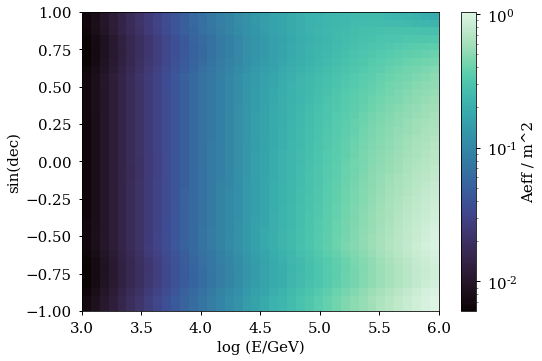

In [166]:
plt.pcolormesh(logE_bins, sindec_bins, aeff_test.T * 1E-4, norm=LogNorm())
plt.xlabel("log (E/GeV)")
plt.ylabel("sin(dec)")
cb = plt.colorbar()
cb.set_label("Aeff / m^2")


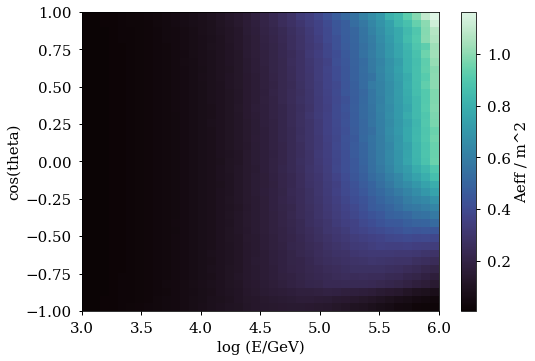

In [163]:
plt.pcolormesh(logE_bins, sindec_bins, aeffs.iloc[0]["aeff_hist"]) #, norm=LogNorm())
plt.xlabel("log (E/GeV)")
plt.ylabel("cos(theta)")
cb = plt.colorbar()
cb.set_label("Aeff / m^2")


# background

In [6]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["nue_total"] + flux_def["nutau_pr"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

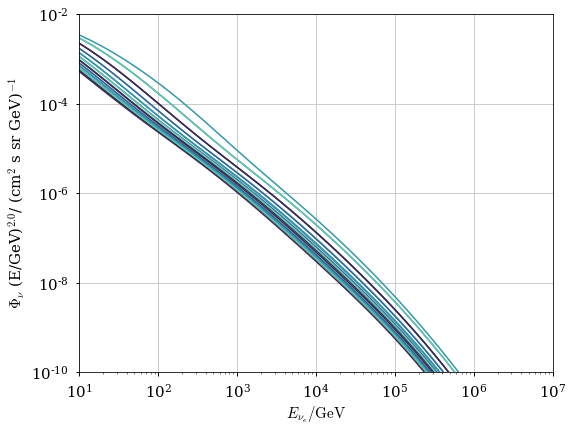

In [7]:
spec = 2.0
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    p0 = ax.loglog(
        e_grid,
        e_grid ** (spec) * flux_def["nue_conv"][:, ti],
        ls="solid",
        lw=1.5,
    )

ax.set_xlim(10, 1e7)
ax.set_ylim(1e-10, 1e-2)
ax.set_xlabel(r"$E_{{{0}}} / {{\rm GeV}}$".format(r"\nu_e"))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "/ (cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


# energy and psi resolution

In [174]:
res_df = pd.read_pickle("../resources/optimization_resolutions.pickle")

# NGC1068 - source parameters

In [144]:
def array_source_interp(dec, array, sindec_mids=sindec_mids):
    low_ind = np.digitize(np.sin(dec), sindec_mids)

    if low_ind >= len(sindec_mids):
        #print("end of range")
        array_interp = array[:, -1]
    elif low_ind == 0:
        #print("low end range")
        array_interp = array[:, low_ind]
    else:
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [sindec_mids[low_ind - 1], sindec_mids[low_ind]],
                [array[i, low_ind - 1], array[i, low_ind]],
            )
        #print(sindec_mids[low_ind - 1], np.sin(dec), sindec_mids[low_ind])
    return array_interp


In [178]:
res_df.loc[ind]

IndexingError: Too many indexers

In [179]:
res_df.index

RangeIndex(start=0, stop=108, step=1)

In [128]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 * 2 # numu + numubar -> nue+nuebar + nutau+nutaubar
E0_NGC = 1E3

# ngc flux error contour
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
# phi_c_68 /= 1E11
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")

In [ ]:
for ind, row in aeffs.iterrows():
    aeff_factor_signal = (
        array_source_interp(0, row["equatorial"])
        * LIVETIME
        * ewidth
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
        smear_energy=False,
    )

## calculate number of events for ngc-like source

In [173]:
delta_psi = 4


In [167]:
n_events = []
for dec in np.arcsin(sindec_mids):
    for ind, row in aeffs.iterrows():
        dct = {"src_dec": dec, "src_sindec": np.sin(dec)}
        for nm, val in zip(aeffs.index.names, ind):
            dct[nm] = val
        aeff_factor_signal = (
            array_source_interp(dec, row["equatorial"])
            * LIVETIME
            * ewidth
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            smear_energy=False,
        )
        dct["n_sig"] = np.sum(k_s)

        aeff_factor_bckg = (
            array_source_interp(dec, row["equatorial"])
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, spl_vals.T).T,
            smear_energy=False,
        )
        dct["n_bg"] = np.sum(k_b)
        dct["s/sqb"] = dct["n_sig"] / np.sqrt(dct["n_bg"])
        n_events.append(dct)
n_events = pd.DataFrame(n_events)


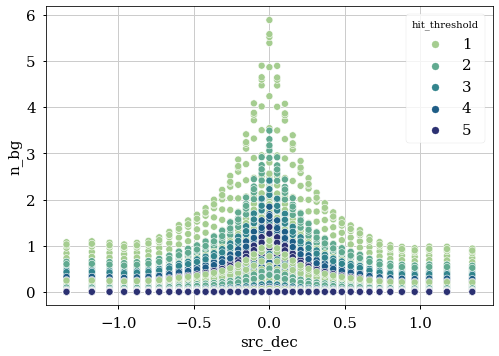

In [157]:
ax = sns.scatterplot(
    data=n_events, x="src_dec", y="n_bg", hue="hit_threshold", palette="crest"
)


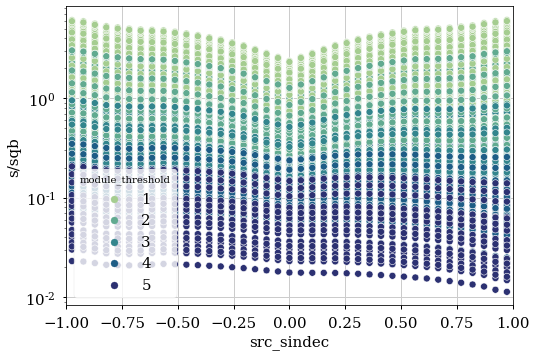

In [172]:
ax = sns.scatterplot(
    data=n_events, x="src_sindec", y="s/sqb", hue="module_threshold", palette="crest"
)
ax.set_xlim(-1, 1)
ax.set_yscale("log")


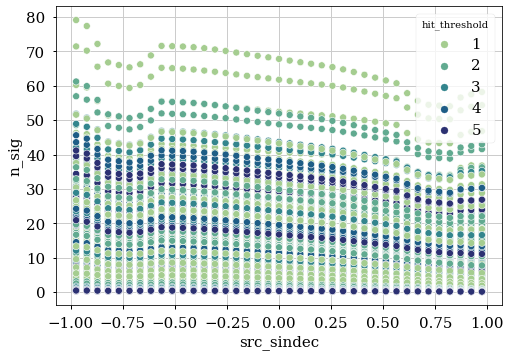

In [165]:
ax = sns.scatterplot(
    data=n_events, #[(n_events.module_threshold == 1) & (n_events.spacing == 30)],
    x="src_sindec",
    y="n_sig",
    hue="hit_threshold",
    palette="crest",
)
